# Analyzing molecular dynamics simulations

In this exercise, we will introduce methods for the analysis of molecular dynamics (MD) simulations. The introduced methods include animated visualization, structural alignment, RMSD calculation, as well as selected atom distances. This exercise was adapted from [talktorial 20 of teachopencadd](https://github.com/volkamerlab/teachopencadd/tree/master/teachopencadd/talktorials/T020_md_analysis), but uses py3Dmol instead of nglview for visualization. py3Dmol should be more familiar from other exercises and I was able to get visualization to work on Google Colab.

We will work with the simulation results (500ps, 50 frames) generated in exercise 8, **Performing a molecular dynamics simulation with OpenMM**, on the EGFR kinase ([PDB: 3POZ](https://www.rcsb.org/structure/3poz)) bound to inhibitor [03P](https://www.rcsb.org/ligand/03P).

# Part 0 - Setting up the required software

The following code cells will install all required packages, if you are working on [Google Colab](https://colab.research.google.com/notebooks/intro.ipynb). Installing the [condacolab](https://github.com/jaimergp/condacolab) package will restart the kernel, which is intended.

In [ ]:
!pip install py3Dmol

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
try:
    !pip install condacolab
    import google.colab
    import condacolab
    condacolab.install()
except ModuleNotFoundError:
    pass

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
⏬ Downloading https://github.com/jaimergp/miniforge/releases/latest/download/Mambaforge-colab-Linux-x86_64.sh...
📦 Installing...
📌 Adjusting configuration...
🩹 Patching environment...
⏲ Done in 0:00:28
🔁 Restarting kernel...


In [ ]:
try:
    import condacolab
    from google.colab import files
    from IPython.display import clear_output
    condacolab.check()
    !conda install -q -y -c conda-forge mdanalysis cudatoolkit
except ModuleNotFoundError:
    on_colab = False
else:
    #check if installation was succesful
    try:
        import openmm
        on_colab = True
        clear_output()  # clear the excessive installation outputs
        print("Dependencies successfully installed!")
    except ModuleNotFoundError:
        print("Error while installing dependencies!")

✨🍰✨ Everything looks OK!
Solving environment: ...working... WARNING conda.core.solve:_add_specs(649): pinned spec cudatoolkit=11.2 conflicts with explicit specs.  Overriding pinned spec.
failed with initial frozen solve. Retrying with flexible solve.
Solving environment: ...working... WARNING conda.core.solve:_add_specs(649): pinned spec cudatoolkit=11.2 conflicts with explicit specs.  Overriding pinned spec.
failed with repodata from current_repodata.json, will retry with next repodata source.
Solving environment: ...working... done

## Package Plan ##

  environment location: /usr/local

  added / updated specs:
    - cudatoolkit
    - mdanalysis


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    biopython-1.79             |   py37h540881e_2         2.6 MB  conda-forge
    brotli-1.0.9               |       h166bdaf_8          18 KB  conda-forge
    brotli-bin-1.0.9           |       h1

In [ ]:
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import py3Dmol

import MDAnalysis as mda
from MDAnalysis.analysis import rms, diffusionmap, align
from MDAnalysis.analysis.distances import dist
from MDAnalysis.analysis.hydrogenbonds.hbond_analysis import HydrogenBondAnalysis as HBA

# Part 1 - Loading the simulation

The results of a standard MD simulation are commonly saved in two file types. 
* *Topology of the system*, which informs about the simulated system, i.e. a defined set of atoms connected via bonds. 
* *Positions of the atoms* over time

Loading both file types into a molecular visualization tool can be used to create an instance of the simulated system. In the below used MD analysis library (`MDAnalysis`), this system is called a *universe*. Our topology is stored in a `.pdb` file and trajectory in a `.dcd`.

If you did not complete exercise 8 or lost the files, you will need to [download example results](https://github.com/daveminh/Chem456-2022F/blob/main/exercises/08-openmm.zip) and decompress the files into `/content/drive/MyDrive/Chem456-2022F/exercises/08-openmm`.

In [ ]:
import os

# Check for directory and input files
if not os.path.isdir('/content/drive'):
  from google.colab import drive
  drive.mount('/content/drive')

exercises_dir = os.path.join('/content','drive','MyDrive',\
  'Chem456-2022F', 'exercises')
if not os.path.isdir(exercises_dir):
  raise ValueError('Exercises directory not set up')
else:
  os.chdir(exercises_dir)

openmm_dir = os.path.join(exercises_dir,'08-openmm')
if not os.path.isdir(openmm_dir):
  os.mkdir('08-openmm')

pdb_FN = os.path.join(openmm_dir, 'complex-solv-eq.pdb')
dcd_FN = os.path.join(openmm_dir, 'complex-solv-eq.dcd')

if not os.path.isfile(pdb_FN):
  raise ValueError(f'Input file {pdb_FN} not found!')
if not os.path.isfile(dcd_FN):
  raise ValueError(f'Input file {dcd_FN} not found!')

# Creates the MDAnalysis universe object 
mda_universe = mda.Universe(pdb_FN, dcd_FN)

Mounted at /content/drive


# Part 2 - Visualization and Alignment

The following function writes out the trajectory as a series of pdb files that can be visualized by py3Dmol.

In [ ]:
def visualize_mda_universe(u, \
    sel_string='not ((resname WAT) or (resname HOH))', 
    style={"cartoon": {'color': 'spectrum'}}):
  """
  Inputs: 
  u : mdanalysis universe
  sel_string : mdanalysis selection string for visible atoms
  style : py3Dmol style
  """
  # The number of frames in the simulation
  number_frames_analysis = len(u.trajectory)
  if number_frames_analysis > 10:
    stride_animation = number_frames_analysis/10
  else:
    stride_animation = 1

  # Deleting previously stored frames as PDBs and removing warnings
  import warnings
  warnings.filterwarnings('ignore')
  !rm [0-9]?.pdb 2> /dev/null
  
    # Helper classes to read and get PDB fields
  class Atom(dict):
    def __init__(self, line):
      self["type"] = line[0:6].strip()
      self["idx"] = line[6:11].strip()
      self["name"] = line[12:16].strip()
      self["resname"] = line[17:20].strip()
      self["resid"] = int(int(line[22:26]))
      self["x"] = float(line[30:38])
      self["y"] = float(line[38:46])
      self["z"] = float(line[46:54])
      self["sym"] = line[76:78].strip()

    def __str__(self):
      line = list(" " * 80)
      line[0:6] = self["type"].ljust(6)
      line[6:11] = self["idx"].ljust(5)
      line[12:16] = self["name"].ljust(4)
      line[17:20] = self["resname"].ljust(3)
      line[22:26] = str(self["resid"]).ljust(4)
      line[30:38] = str(self["x"]).rjust(8)
      line[38:46] = str(self["y"]).rjust(8)
      line[46:54] = str(self["z"]).rjust(8)
      line[76:78] = self["sym"].rjust(2)
      return "".join(line) + "\n"
          
  class Molecule(list):
    def __init__(self, file):
      for line in file:
        if "ATOM" in line or "HETATM" in line:
          self.append(Atom(line))
              
      def __str__(self):
        outstr = ""
        for at in self:
          outstr += str(at)
        return outstr

  # Write out frames for animation
  protein = u.select_atoms(sel_string) 
  i = 0
  for ts in u.trajectory[0:len(u.trajectory):int(stride_animation)]: 
      if i > -1:
          with mda.Writer('' + str(i) + '.pdb', protein.n_atoms) as W:
              W.write(protein)
      i = i + 1
  # Load frames as molecules (py3Dmol let us visualize a single "molecule" per frame)
  molecules = []
  for i in range(int(len(u.trajectory)/int(stride_animation))):
      with open('' + str(i) + '.pdb') as ifile:
          molecules.append(Molecule(ifile))

  models = ""
  for i in range(len(molecules)):
    models += "MODEL " + str(i) + "\n"
    for j,mol in enumerate(molecules[i]):
      models += str(mol)
    models += "ENDMDL\n"

  # Animation
  view = py3Dmol.view(width=800, height=600)
  view.addModelsAsFrames(models)
  for i, at in enumerate(molecules[0]):
      view.setStyle({'model': -1, 'serial': i+1}, at.get("pymol", style))

  view.zoomTo()
  view.animate({'loop': "forward", 'reps': 0})
  return view

Let us look at the trajectory.

In [ ]:
view = visualize_mda_universe(mda_universe)
view.show()

Output hidden; open in https://colab.research.google.com to view.

### Alignment

Although barely noticable in the visualization of this rather short trajectory, depending on the used simulation package/settings proteins can rotate and translate during simulation. This can complicate visual inspection of the trajectory and usually requires an alignment as as prior step to analysis. A common selection for aligning a trajectory on is the protein. Thus, the protein will not deviate from the center and not rotate allowing the observation of unbinding events or conformational changes. 

The [MDAnalysis](https://docs.mdanalysis.org/stable/index.html) framework allows for easy alignment on an atom selection using strings and has built-in simple selection keywords as well, for example "protein", which selects all residues usually belonging to the protein. 

In the next step, we will align the structures of the trajectory (mobile) onto the reference structure. The frame currently active in the reference structure will be used for alignment.

In [ ]:
# Set trajectory pointer to first frame as reference
mda_universe.trajectory[0]

# in_memory=True is needed to actually modify the loaded trajectory
# if the trajectory is too big for memory, one can write out the aligned trajectory and reload it into a new universe
alignment = align.AlignTraj(
    mobile=mda_universe, reference=mda_universe, select="protein", in_memory=True
)
alignment.run()

In [ ]:
view = visualize_mda_universe(mda_universe)
view.show()

Output hidden; open in https://colab.research.google.com to view.

# Part 3 - Root mean square deviation and fluctuation

A more sophisticated method to track conformational changes is the calculation of the root-mean-square deviation (RMSD, [wikipedia](https://en.wikipedia.org/wiki/Root-mean-square_deviation_of_atomic_positions)). This method measures the deviation of atom positions compared to a reference set of atom positions. RMSD plots can be employed to depict the relative movement of whole proteins or their domains during folding or drug binding. Also, RMSD calculations can be used to compare computed docking configurations to known (i.e. crystallographic) binding poses to validate the docking protocol.

For two, usually superimposed, sets of atom coordinates v and w with n elements, the RMSD is defined as follows:

$$RMSD(v,w) = \frac{1}{n} \sum_{i=1}^n \|v_i - w_i\|²$$

To differentiate flexible and stable portions of a protein in simulations, one can use the root-mean-square fluctuation (RMSF) calculation instead, which allows for visualization of the fluctuation of residues from their mean structure.

RMSD and RMSF may be calculated for different portions of a system, e.g. backbone, protein and ligand. The ligand is best selected by its distinct residue name. In this case, we know it is the inhibitor `03P`.

In [ ]:
ligand_name = "03P"

#### RMSD over time

For plotting the RMSD, we write a function that does the RMSD calculation for selected atom groups from the universe and returns a pandas `Dataframe`.

In [ ]:
def rmsd_for_atomgroups(universe, selection1, selection2=None):
    """Calulate the RMSD for selected atom groups.

    Parameters
    ----------
    universe: MDAnalysis.core.universe.Universe
        MDAnalysis universe.
    selection1: str
        Selection string for main atom group, also used during alignment.
    selection2: list of str, optional
        Selection strings for additional atom groups.

    Returns
    -------
    rmsd_df: pandas.core.frame.DataFrame
        DataFrame containing RMSD of the selected atom groups over time.
    """

    universe.trajectory[0]
    ref = universe
    rmsd_analysis = rms.RMSD(universe, ref, select=selection1, groupselections=selection2)
    rmsd_analysis.run()
    columns = [selection1, *selection2] if selection2 else [selection1]
    rmsd_df = pd.DataFrame(np.round(rmsd_analysis.rmsd[:, 2:], 2), columns=columns)
    rmsd_df.index.name = "frame"
    return rmsd_df

Run the function to calculate the RMSD for the selected molecules during the simulation:

* whole protein
* protein backbone atoms 
* ligand

During the calculation, the molecule will be superimposed to the first frame (reference) along the backbone of the protein.

In [ ]:
rmsd = rmsd_for_atomgroups(mda_universe, "backbone", ["protein", f"resname {ligand_name}"])
rmsd.head()

,backbone,protein,resname 03P
frame,,,
0,0.00,0.00,0.00
1,0.72,1.03,0.68
2,0.77,1.13,1.03
3,0.88,1.28,1.27
4,0.90,1.34,1.48


Then, we plot the results.

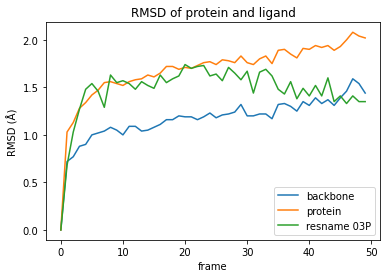

In [ ]:
rmsd.plot(title="RMSD of protein and ligand")
plt.ylabel("RMSD (Å)");

#### --> Why does the RMSD increase so rapidly at the beginning of the simulation?

#### --> How does the RMSD of the backbone compare to the protein? Why?

#### --> How does the RMSD of the ligand compare to the protein? What would it mean if the RMSD of the ligand was much larger?

#### --> We initially calculated the RMSD based on alignment of the backbone. Now perform an alignment based on the ligand. How do RMSD trends change?

#### RMSD between frames

The plot before showed the distance at the given time compared to the initial state.
Now, we calculate the differences between all frames (pair-wise) and visualize them in a heatmap.

In [ ]:
def RMSD_dist_frames(universe, selection):
    """Calculate the RMSD between all frames in a matrix.

    Parameters
    ----------
    universe: MDAnalysis.core.universe.Universe
        MDAnalysis universe.
    selection: str
        Selection string for the atomgroup to be investigated, also used during alignment.

    Returns
    -------
    array: np.ndarray
        Numpy array of RMSD values.
    """
    pairwise_rmsd = diffusionmap.DistanceMatrix(universe, select=selection)
    pairwise_rmsd.run()
    return pairwise_rmsd.dist_matrix

First, we calculate the distance matrices for protein and ligand using the function above.
Then, we plot them side by side as heatmaps.

In [ ]:
dist_matrix_protein = RMSD_dist_frames(mda_universe, "protein")
dist_matrix_ligand = RMSD_dist_frames(mda_universe, f"resname {ligand_name}")

In order to achieve comparable heatmaps, it is important to set the minima and maxima in both plots to the same values. 
We set the minimal value to 0 and derive the upper bound from the distance matrices.

In [ ]:
# get maximal distance between all frames
max_dist = max(np.amax(dist_matrix_ligand), np.amax(dist_matrix_protein))

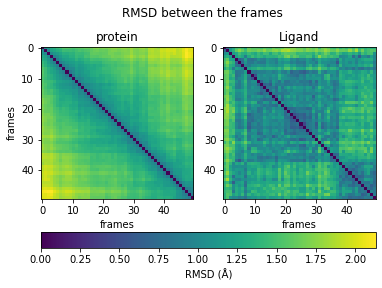

In [ ]:
fig, ax = plt.subplots(1, 2)
fig.suptitle("RMSD between the frames")

# protein image
img1 = ax[0].imshow(dist_matrix_protein, cmap="viridis", vmin=0, vmax=max_dist)
ax[0].title.set_text("protein")
ax[0].set_xlabel("frames")
ax[0].set_ylabel("frames")

# ligand image
img2 = ax[1].imshow(dist_matrix_ligand, cmap="viridis", vmin=0, vmax=max_dist)
ax[1].title.set_text("Ligand")
ax[1].set_xlabel("frames")

fig.colorbar(img1, ax=ax, orientation="horizontal", fraction=0.1, label="RMSD (Å)")

#### --> Based on the heatmaps, what can you conclude about the motion of the protein and ligand?

#### --> Use `MDAnalysis.analysis.rms.RMSF` to calculate the RMSF for the protein.

In [ ]:
# MDAnalysis.analysis.rms.RMSF

# Part 4 - Interaction analysis

Now, we will look at the interaction between protein and ligand. Let's visualize the system again, including some more detail in the binding pocket. All residues in a 7 Å radius around the ligand are shown with atoms and bonds visible.

In [ ]:
view = visualize_mda_universe(mda_universe, 
  sel_string = f"resname {ligand_name} or ((around 7 resname {ligand_name}) and protein)", \
  style = {'stick':{}})
view.show()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

#### Atomic distances

We now zoom in and look for interactions that might be of interest for a project at hand. In this example, we want to look at the backbone nitrogen of methionine 793 coming in close contact with an aromatic ring of the ligand. Theoretically, the distances can be calculated for groups of atoms, as long as each group has the same number of atoms, but we want to look at distances between single atoms.
Single atom selections can be done unambiguously with the combination of residue id and atom name inside that residue. Residue names are not unique and thus are not be used here.

In [ ]:
protein_residue_id = "793"
protein_atom_name = "N"
ligand_id = "1"
ligand_atom_name = "N4"

We select the atom groups used for our analysis, which will contain one atom each in this example.

In [ ]:
atomgroup_protein = mda_universe.select_atoms(
    f"resid {protein_residue_id} and name {protein_atom_name}"
)
atomgroup_ligand = mda_universe.select_atoms(f"resname {ligand_name} and name {ligand_atom_name}")

Now, we can calculate the distance between the atoms in the currently set frame of our universe (using the `dist`function from `MDAnalysis`).
The function returns an array of arrays: The first two elements are the residue ids, but we are only interested in the third entry, the distance.

In [ ]:
distance = dist(atomgroup_protein, atomgroup_ligand)
print(
    f"The distance between residues {protein_residue_id} and {ligand_atom_name} is {distance[2][0]:.2f} Å"
)

The distance between residues 793 and N4 is 3.16 Å


To gather more information we want to look at the development of the distance over time. We can iterate over the frames and calculate the distance for each of them. The trajectory property of the universe works as a pointer and only holds information about one time step. The pointer is moved along the trajectory file, any selections are automatically updated on the way.

In [ ]:
distances = []
for _ in mda_universe.trajectory:
    distance = dist(atomgroup_protein, atomgroup_ligand)
    distances.append(distance[2][0])

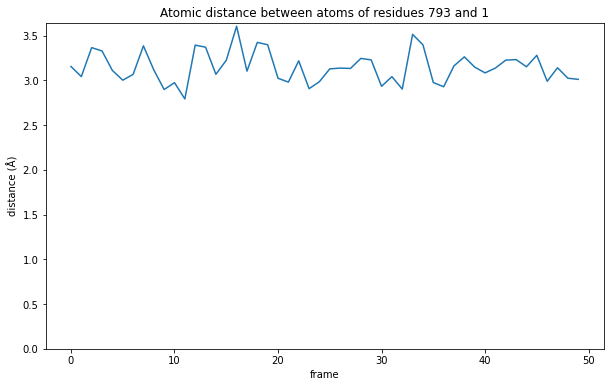

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(distances)
plt.gca().set_ylim(bottom=0)
plt.ylabel("distance (Å)")
plt.xlabel("frame")
plt.title(f"Atomic distance between atoms of residues {protein_residue_id} and {ligand_id}")
plt.show()

#### --> Describe how this distance changes over the course of the trajectory.

#### Hydrogen bond analysis

Non-covalent interations like hydrogen bonds are key-players in the formation of a ligand-protein complex ([_PLoS One._ (2010), **5(8)**, e12029](https://doi.org/10.1371%2Fjournal.pone.0012029), [_J. Med. Chem._ 2010, **53(14)**, 5061-84](https://doi.org/10.1021/jm100112j)). Their attractive potential results from a partially positively charged hydrogen pointing to a partially negatively charged hydrogen bond acceptor atom, e.g. oxygen or nitrogen. The analysis of hydrogen bonds can give valuable insights into the stability of a ligand-protein complex and guide modification of a lead molecule to improve its activity. The strength of a hydrogen bond can be estimated by analyzing angles and distances between donor, hydrogen and acceptor atoms. A small distance and an angle close to 180° indicate a strong bond, while bigger distances and smaller angles point towards a weaker bond (Fig 2).

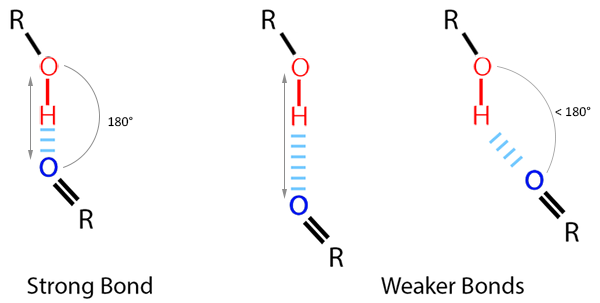
  
Fig. 2: Hydrogen Bond examples between a donor (red) and acceptor (blue) oxygen atom showing different bond angles and distances (arrows), created by *Mareike Leja, CADD Seminar 2020*

For computational analysis, geometric thresholds are often employed to determine which interactions can be considered a hydrogen bond: The distance between acceptor and hydrogen has to be less than or equal to a distance threshold and the angle between donor, hydrogen and acceptor needs to be greater than or equal to an angle threshold. For example, the Python Package __[MDAnalysis](https://www.mdanalysis.org/docs/documentation_pages/analysis/hbond_analysis.html)__, which we will use for analysis, sets the default maximum distance at 3 Å and the minimum angle at 120°.

As it happens, the interaction with the hinge region we are analyzing forms a hydrogen bond. The nitrogen of the backbone from methionine is acting as the donor, the nitrogen in the aromatic ring of the ligand is the acceptor.

We go back to the visualization to get the unique name of the hydrogen forming the bond .Then, we can use the hydrogen bond analysis capability from [MDAnalysis](https://docs.mdanalysis.org/1.0.0/documentation_pages/analysis/hydrogenbonds.html) to determine the characteristic distances and angles for the hydrogen bond. The hydrogen bond analysis covers all frames without manual iteration and is convenient to plot.

In [ ]:
hydrogen_name = "H"

In [ ]:
def run_hydrogenbond_analysis(
    universe,
    donor_resid,
    donor_atom,
    hydrogen_atom,
    acceptor_resid,
    acceptor_atom,
    h_cutoff=1.2,
    a_cutoff=3.0,
    angle_cutoff=120,
):
    """
    Perform an hydrogen bond analysis between selcted atom groups.
    Return the data as readable, formatted data frame.

    Parameters
    ----------
    universe: MDAnalysis.core.universe.Universe
        MDAnalysis universe.
    donor_resid: str
        Residue Id of residue containing donor atom in MDAnalysis universe.
    donor_atom: str
        Name of the donor atom in the MDAnalysis universe.
    hydrogen_atom: str
        Name of involved hydrogen atom in the MDAnalysis universe.
    acceptor_resid: str
        Residue Id of residue containing acceptor atom in the MDAnalysis universe.
    acceptor_atom: str
        Name of the acceptor atom in the MDAnalysis universe.
    h_cutoff: float, optional
        Distance cutoff used for finding donor-hydrogen pairs.
    a_cutoff: float, optional
        Donor-acceptor distance cutoff for hydrogen bonds.
    angle_cutoff: int, optional
        D-H-A angle cutoff for hydrogen bonds.

    Returns
    -------
    bond : pandas.core.frame.DataFrame
        DataFrame containing hydrogen bond information over time.
    """

    # set up and run the hydrogen bond analysis (HBA)
    hbonds = HBA(
        universe=universe,
        donors_sel="resid " + donor_resid + " and name " + donor_atom,
        hydrogens_sel="resid " + donor_resid + " and name " + hydrogen_atom,
        acceptors_sel="resid " + acceptor_resid + " and name " + acceptor_atom,
        d_h_cutoff=h_cutoff,
        d_a_cutoff=a_cutoff,
        d_h_a_angle_cutoff=angle_cutoff,
    )
    hbonds.run()
    # extract bond data
    bond = pd.DataFrame(np.round(hbonds.hbonds, 2))
    # name columns (according to MDAnalysis function description)
    bond.columns = [
        "frame",
        "donor_index",
        "hydrogen_index",
        "acceptor_index",
        "distance",
        "angle",
    ]
    # set frame as the index
    bond["frame"] = bond["frame"].astype(int)
    bond.set_index("frame", inplace=True, drop=True)
    return bond

We run the hydrogen bond analysis using our function, which returns a data frame.

In [ ]:
bond = run_hydrogenbond_analysis(
    mda_universe, protein_residue_id, protein_atom_name, hydrogen_name, ligand_id, ligand_atom_name
)
bond.head()

,donor_index,hydrogen_index,acceptor_index,distance,angle
frame,,,,,
9,1483.0,1484.0,5529.0,2.90,170.04
10,1483.0,1484.0,5529.0,2.98,152.49
11,1483.0,1484.0,5529.0,2.79,160.89
21,1483.0,1484.0,5529.0,2.98,170.82
23,1483.0,1484.0,5529.0,2.91,155.91


In the table, we can see that the bond is only recognized in some frames during the simulation. 

The used module searches for hydrogen bonds with strict predefined constraints. Using default settings, the bond is only detected if the distance larger than 3Å between donor and acceptor and smaller than 1.2Å between donor and hydrogen and if the angle is larger than 120° (see Figure 1). The bond will not be included for frames that do not meet the constraints.

To trace the bond over the entire simulation, we can change those thresholds to detect the bond in its "weaker" states.
From the above table, the angles seem to be sufficiently high, while the distances are closer to the 3Å cutoff distance. Thus, we try the analysis again with a higher distance cutoff of 5Å for the donor and acceptor distance.

In [ ]:
bond = run_hydrogenbond_analysis(
    mda_universe,
    protein_residue_id,
    protein_atom_name,
    hydrogen_name,
    ligand_id,
    ligand_atom_name,
    a_cutoff=5.0,
)
bond.head()

,donor_index,hydrogen_index,acceptor_index,distance,angle
frame,,,,,
0,1483.0,1484.0,5529.0,3.16,153.32
1,1483.0,1484.0,5529.0,3.04,171.63
2,1483.0,1484.0,5529.0,3.37,156.48
3,1483.0,1484.0,5529.0,3.33,171.93
4,1483.0,1484.0,5529.0,3.11,173.42


Now, we plot the bond.

In [ ]:
def plot_hydrogen_bond_over_time(bond):
    """
    Plot the distance and degree of a chosen hydrogen bond over time.
    Peaks in angle and dips in distance represent moments of strong binding.

    Parameters
    ----------
    bond: pandas.core.frame.DataFrame
        Hydrogen bond analysis data frame with named columns.
    """

    donor_index = bond.iloc[0].donor_index
    acceptor_index = bond.iloc[0].acceptor_index

    # add values for missing frames for gapless plotting
    bond = bond.reindex(np.arange(0, 99))

    # plot the data
    fig = plt.figure(figsize=(10, 6))
    distance = bond.distance.plot(
        title=f"H-Bond between donor {donor_index} and acceptor {acceptor_index}",
        style="o-",
        x="frame",
    )
    distance.set_ylabel("distance (Å)")
    distance.set_xlabel("frame")
    distance.set_ylim(bottom=0)
    angle = bond.angle.plot(secondary_y=True, style="o-", x="frame")
    angle.set_ylabel("angle (°)")
    angle.set_xlabel("frame")
    angle.set_ylim(bottom=0)
    fig.legend(loc="lower right", bbox_to_anchor=(1, 0), bbox_transform=distance.transAxes)
    plt.show()

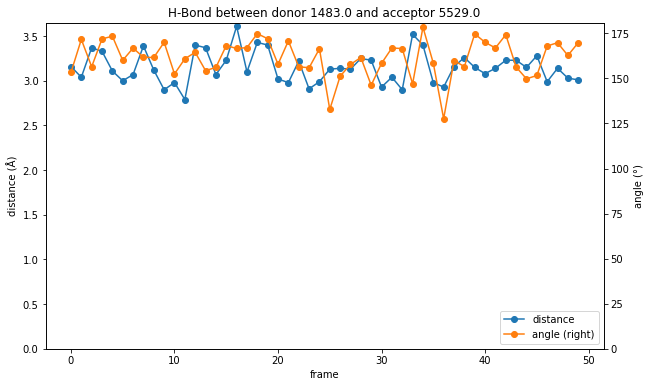

In [ ]:
plot_hydrogen_bond_over_time(bond)

While the distance values in the hydrogen bond analysis are the same we have seen in the pure distance plot above, the combination with the bond angle elevates the information. As mentioned before, the distance is at the upper end for hydrogen bond lengths throughout the simulation, but the bond angle is consistently close to 180° and stabilizes the bond. From the analysis we could assume that the interaction between the backbone methionine in the kinase hinge region is indeed a crucial factor for the binding of the ligand.

#### --> Which hydrogen bond is the strongest?
- A: donor acceptor distance = 3.5 Å, donor hydrogen acceptor angle = 170°
- B: donor acceptor distance = 2.7 Å, donor hydrogen acceptor angle = 180°
- C: donor acceptor distance = 3.2 Å, donor hydrogen acceptor angle = 150°

## Discussion

There are various ways to analyze MD simulations. In this talktorial, we explored only a small fraction of available methods to give the user first insights. Some methods are more straightforward, like the visualization of the system or the calculation of the RMSD, while others require more finesse. Especially the hydrogen bond analysis is yet dependent on manual input and tweaking. But with further advancements in the field, we can expect the frameworks to become more and more refined.

The MD simulation used during analysis is actually too short to provide statistical significant data on binding and unbinding events or even conformational changes of the protein or ligand. To make full use of the capabilities of MD simulations one needs access to high performance clusters. Great examples on insights gained from MD simulations can be found on the webpage of the [Folding@home](https://foldingathome.org/) consortium, which connects computers world wide to address pressing scientific challenges.

### References

Theoretical Background:

- Review on the impact of MD simulations in drug discovery ([_J Med Chem_ (2016), **59**(9), 4035‐4061](https://doi.org/10.1021/acs.jmedchem.5b01684))
- Review on force fields ([_J Chem Inf Model_ (2018), **58**(3), 565-578](https://doi.org/10.1021/acs.jcim.8b00042))
- Review on hydrogen bonding ([_PLoS One._ (2010), **5(8)**, e12029](https://doi.org/10.1371%2Fjournal.pone.0012029))
- Guide to molecular interactions ([_J. Med. Chem._ 2010, **53(14)**, 5061-84](https://doi.org/10.1021/jm100112j))
- Wikipedia Article about [root-mean-square deviation](https://en.wikipedia.org/wiki/Root-mean-square_deviation)
- Repositories of [MDAnalysis](https://www.mdanalysis.org/) and [NGL View](https://github.com/arose/nglview)